In [22]:
import pandas as pd
import csv
import matplotlib.pyplot as plt

MESSAGE_CODE_FILTER = ["50102", "50103"]

In [23]:
file_path = r"C:\Users\joacosta\Work\Beumer\ORF5\Data Analitics\Extracted\Log Monitor\10-22-2025\Logs_Oct-22.csv"
raw_df = pd.read_csv(
    file_path,
    sep=";",
    header=None,
    engine="python",
    quoting=csv.QUOTE_NONE,
    skipinitialspace=True,
    on_bad_lines="skip",
    dtype=str
)

In [24]:
temp_df = raw_df.replace('"', '',regex=True)        # Remove all double quotes
temp_df = temp_df.replace(r"\s+", '',regex=True)    # Remove all whitespace

temp_df.columns = [
    "timeStamp", "flag", "systemName", "ipAddress", "sender", "unkown",
    "unkown_2", "timeStampPLC", "mainCabinetName", "messageCode", "sequenceNo",
    "rawMessage"
]

# timeStamp parsing
temp_df["timeStamp"] = pd.to_datetime(temp_df["timeStamp"], format="%y%m%d%H%M%S%f", errors="coerce")

# Filter to keep only rows with messageCode in MESSAGE_CODE_FILTER
original_records = len(temp_df)
temp_df = temp_df[temp_df["messageCode"].isin(MESSAGE_CODE_FILTER)].reset_index(drop=True)

remaining_records = len(temp_df)
dropped_count = original_records - remaining_records
print(f"Filtered dataset: kept {remaining_records} rows with messageCode in {MESSAGE_CODE_FILTER} "
      f"\n\tdropped {dropped_count} out of {original_records} total rows")

Filtered dataset: kept 44953 rows with messageCode in ['50102', '50103'] 
	dropped 1034188 out of 1079141 total rows


In [25]:
print(temp_df["rawMessage"].iloc[0])

->{event:iuItemMeasurement,inductionNo:1,indexNo,621,length:457,width:504,positionFront:539,positionBack:0,noOfCarriers:2,inductDelay:254,carrierDelay1:89,carrierDelay2:65}<


In [26]:
regex_fix_after_commas = r',\s*([A-Za-z_]\w*)\s*,\s*([-+]?\d+(?:\.\d+)?)'
regex_fix_before_commas = r'^\s*([A-Za-z_]\w*)\s*,\s*([-+]?\d+(?:\.\d+)?)'

In [27]:
# Message Column parsing
temp_df["rawMessage"] = temp_df["rawMessage"].str.removeprefix("->{").str.removesuffix("}<")
temp_df["rawMessage"] = temp_df["rawMessage"].str.replace(regex_fix_after_commas, r',\1:\2', regex=True)  # # fix ", key , 123" after commas
temp_df["rawMessage"] = temp_df["rawMessage"].str.replace(regex_fix_before_commas, r'\1:\2', regex=True)  # fix "key , 123" at the beginning (before the first comma)
message_df = temp_df["rawMessage"].str.split(",", expand=True)          # Split into columns
col_names = message_df.iloc[0].str.split(":", n=1).str[0].str.strip()   # Extract keys (before ':') from the first row as column names
message_df.columns = col_names                                          # Assign new column names
message_df = message_df.apply(lambda x: x.str.split(":", n=1).str[1])   # Keep only values (after ':')
message_df = message_df.apply(pd.to_numeric, errors="ignore")            # Convert to numeric where possible


C:\Users\joacosta\AppData\Local\Temp\ipykernel_43188\2323745790.py:9: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  message_df = message_df.apply(pd.to_numeric, errors="ignore")            # Convert to numeric where possible


In [28]:
message_df.head(1)

,event,inductionNo,indexNo,length,width,positionFront,positionBack,noOfCarriers,inductDelay,carrierDelay1,carrierDelay2,None
0,iuItemMeasurement,1,621,457,504,539,0,2,254,89,65,NaN


In [29]:
# Induction Mapping
induction_map = {
    0: "IU001",
    1: "IU002",
    2: "IU003",
    3: "IU004",
    4: "IU005",
    5: "IU006",
    6: "IU007",
    100: "SPS001",
    101: "SPS002",
    }

# Map InductionNo with the real world names (unknowns -> "No Map Yet")
message_df["inductionNo"] = message_df["inductionNo"].map(induction_map).fillna("No Map Yet")

In [30]:
# Join dataframes
parsed_df = pd.concat([temp_df.drop(columns=["rawMessage"]), message_df], axis=1)
parsed_df = parsed_df.apply(pd.to_numeric, errors="ignore")

C:\Users\joacosta\AppData\Local\Temp\ipykernel_43188\2780915994.py:3: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  parsed_df = parsed_df.apply(pd.to_numeric, errors="ignore")


In [31]:
parsed_df.describe()

,timeStamp,unkown,unkown_2,messageCode,indexNo,length,width,positionFront,positionBack,noOfCarriers,inductDelay,carrierDelay1,carrierDelay2,None
count,4.495300e+04,0.0,0.0,44953.000000,44953.000000,44953.000000,44953.000000,44953.000000,44953.0,44953.000000,44953.000000,44953.000000,44953.000000,39601.000000
mean,1.761147e+18,NaN,NaN,50102.119058,1006.962561,316.006095,366.102240,368.880764,0.0,1.119058,242.262919,186.732031,86.509265,87.996995
std,1.549835e+13,NaN,NaN,0.323860,575.265018,102.949925,146.681618,133.225334,0.0,0.323860,26.340025,42.046596,14.516591,11.051405
min,1.761121e+18,NaN,NaN,50102.000000,1.000000,0.000000,0.000000,11.000000,0.0,1.000000,96.000000,51.000000,33.000000,33.000000
25%,1.761133e+18,NaN,NaN,50102.000000,513.000000,240.000000,275.000000,275.000000,0.0,1.000000,226.000000,177.000000,77.000000,79.000000
50%,1.761145e+18,NaN,NaN,50102.000000,1011.000000,313.000000,345.000000,352.000000,0.0,1.000000,243.000000,197.000000,83.000000,85.000000
75%,1.761162e+18,NaN,NaN,50102.000000,1504.000000,376.000000,421.000000,432.000000,0.0,1.000000,259.000000,212.000000,99.000000,97.000000
max,1.761174e+18,NaN,NaN,50103.000000,1999.000000,1269.000000,1520.000000,1228.000000,0.0,2.000000,348.000000,298.000000,135.000000,131.000000


In [32]:
parsed_df.select_dtypes(include=['object', 'category']).describe()

,flag,systemName,ipAddress,sender,timeStampPLC,mainCabinetName,sequenceNo,event,inductionNo
count,44953,44953,44953,44953,44953,44953,44953,44953,44953
unique,1,1,1,1,44831,1,256,1,7
top,N,SMC,10.158.244.100:7200,Induction.Item,"13:57:03,624",MC01,SQ250,iuItemMeasurement,IU002
freq,44953,44953,44953,44953,2,44953,215,44953,11069


In [33]:
cols_to_drop = parsed_df.columns[parsed_df.nunique() == 1].tolist()
print(f"Dropping {len(cols_to_drop)} columns with a single unique value: {cols_to_drop}")
clean_df = parsed_df.drop(columns=cols_to_drop)

clean_df = clean_df.dropna(axis=1, how="all")
clean_df.info()

Dropping 7 columns with a single unique value: ['flag', 'systemName', 'ipAddress', 'sender', 'mainCabinetName', 'event', 'positionBack']
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44953 entries, 0 to 44952
Data columns (total 14 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   timeStamp      44953 non-null  int64  
 1   timeStampPLC   44953 non-null  object 
 2   messageCode    44953 non-null  int64  
 3   sequenceNo     44953 non-null  object 
 4   inductionNo    44953 non-null  object 
 5   indexNo        44953 non-null  int64  
 6   length         44953 non-null  int64  
 7   width          44953 non-null  int64  
 8   positionFront  44953 non-null  int64  
 9   noOfCarriers   44953 non-null  int64  
 10  inductDelay    44953 non-null  int64  
 11  carrierDelay1  44953 non-null  int64  
 12  carrierDelay2  44953 non-null  int64  
 13  None           39601 non-null  float64
dtypes: float64(1), int64(10), object(3)
memory us

In [34]:
clean_df.describe()

,timeStamp,messageCode,indexNo,length,width,positionFront,noOfCarriers,inductDelay,carrierDelay1,carrierDelay2,None
count,4.495300e+04,44953.000000,44953.000000,44953.000000,44953.000000,44953.000000,44953.000000,44953.000000,44953.000000,44953.000000,39601.000000
mean,1.761147e+18,50102.119058,1006.962561,316.006095,366.102240,368.880764,1.119058,242.262919,186.732031,86.509265,87.996995
std,1.549835e+13,0.323860,575.265018,102.949925,146.681618,133.225334,0.323860,26.340025,42.046596,14.516591,11.051405
min,1.761121e+18,50102.000000,1.000000,0.000000,0.000000,11.000000,1.000000,96.000000,51.000000,33.000000,33.000000
25%,1.761133e+18,50102.000000,513.000000,240.000000,275.000000,275.000000,1.000000,226.000000,177.000000,77.000000,79.000000
50%,1.761145e+18,50102.000000,1011.000000,313.000000,345.000000,352.000000,1.000000,243.000000,197.000000,83.000000,85.000000
75%,1.761162e+18,50102.000000,1504.000000,376.000000,421.000000,432.000000,1.000000,259.000000,212.000000,99.000000,97.000000
max,1.761174e+18,50103.000000,1999.000000,1269.000000,1520.000000,1228.000000,2.000000,348.000000,298.000000,135.000000,131.000000


In [35]:
clean_df.select_dtypes(include=['object', 'category']).describe()

,timeStampPLC,sequenceNo,inductionNo
count,44953,44953,44953
unique,44831,256,7
top,"13:57:03,624",SQ250,IU002
freq,2,215,11069


In [36]:
# we need to conver message code into a categorical column right now is just 50102 and 50103

clean_df["messageCode"] = clean_df["messageCode"].astype("category")

In [37]:
clean_df.describe()

,timeStamp,indexNo,length,width,positionFront,noOfCarriers,inductDelay,carrierDelay1,carrierDelay2,None
count,4.495300e+04,44953.000000,44953.000000,44953.000000,44953.000000,44953.000000,44953.000000,44953.000000,44953.000000,39601.000000
mean,1.761147e+18,1006.962561,316.006095,366.102240,368.880764,1.119058,242.262919,186.732031,86.509265,87.996995
std,1.549835e+13,575.265018,102.949925,146.681618,133.225334,0.323860,26.340025,42.046596,14.516591,11.051405
min,1.761121e+18,1.000000,0.000000,0.000000,11.000000,1.000000,96.000000,51.000000,33.000000,33.000000
25%,1.761133e+18,513.000000,240.000000,275.000000,275.000000,1.000000,226.000000,177.000000,77.000000,79.000000
50%,1.761145e+18,1011.000000,313.000000,345.000000,352.000000,1.000000,243.000000,197.000000,83.000000,85.000000
75%,1.761162e+18,1504.000000,376.000000,421.000000,432.000000,1.000000,259.000000,212.000000,99.000000,97.000000
max,1.761174e+18,1999.000000,1269.000000,1520.000000,1228.000000,2.000000,348.000000,298.000000,135.000000,131.000000


In [38]:
clean_df.select_dtypes(include=['object', 'category']).describe()

,timeStampPLC,messageCode,sequenceNo,inductionNo
count,44953,44953,44953,44953
unique,44831,2,256,7
top,"13:57:03,624",50102,SQ250,IU002
freq,2,39601,215,11069


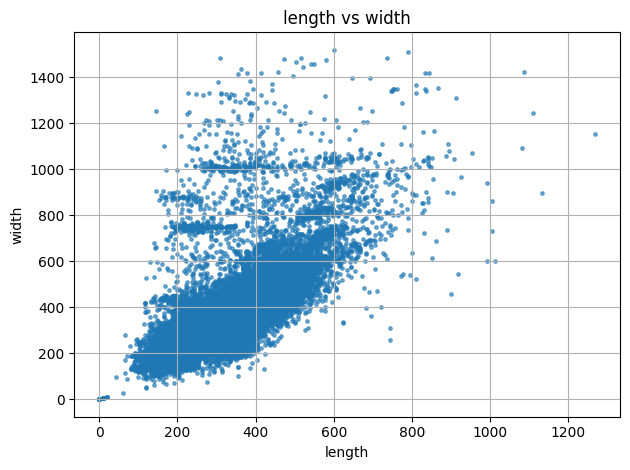

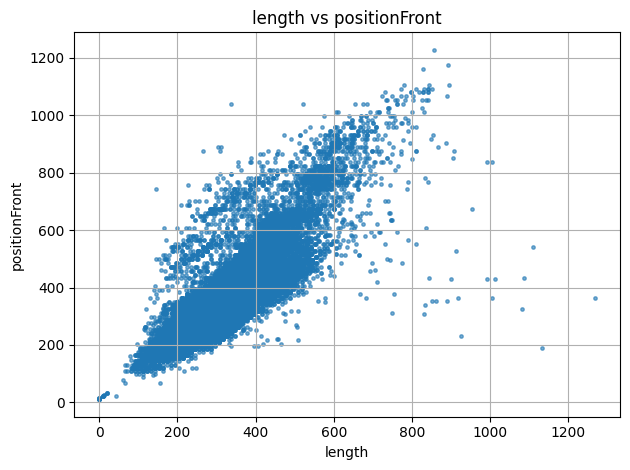

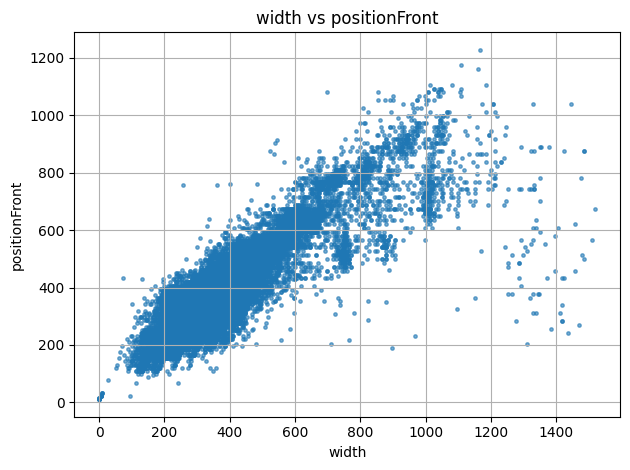

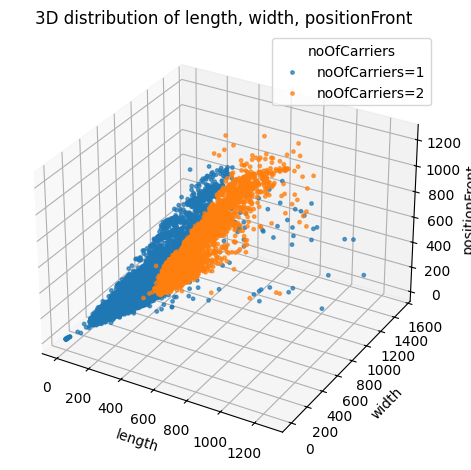

In [39]:
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 (needed for 3D)

# --- CONFIG ---
X, Y, Z = "length", "width", "positionFront"
GROUP = "noOfCarriers"   # used to color series in the 3D plot
MAX_POINTS = 50000       # subsample for speed if needed

# Make sure the columns exist and are numeric
for col in [X, Y, Z, GROUP]:
    if col in clean_df.columns:
        clean_df[col] = pd.to_numeric(clean_df[col], errors="coerce")

# Drop rows missing the key columns
df = clean_df[[X, Y, Z, GROUP]].dropna(subset=[X, Y, Z]).copy()

# Optional: subsample (preserves distribution reasonably for big datasets)
if len(df) > MAX_POINTS:
    df = df.sample(MAX_POINTS, random_state=42)

# 1) length vs width
plt.figure()
plt.scatter(df[X], df[Y], s=6, alpha=0.6)
plt.xlabel(X)
plt.ylabel(Y)
plt.title(f"{X} vs {Y}")
plt.grid(True)
plt.tight_layout()

# 2) length vs positionFront
plt.figure()
plt.scatter(df[X], df[Z], s=6, alpha=0.6)
plt.xlabel(X)
plt.ylabel(Z)
plt.title(f"{X} vs {Z}")
plt.grid(True)
plt.tight_layout()

# 3) width vs positionFront
plt.figure()
plt.scatter(df[Y], df[Z], s=6, alpha=0.6)
plt.xlabel(Y)
plt.ylabel(Z)
plt.title(f"{Y} vs {Z}")
plt.grid(True)
plt.tight_layout()

# 4) 3D scatter (length, width, positionFront) with different colors per group (default color cycle)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

if GROUP in df.columns:
    # Plot each group separately to get different default colors and a legend
    for g, gdf in df.groupby(GROUP):
        ax.scatter(gdf[X], gdf[Y], gdf[Z], s=6, alpha=0.7, label=f"{GROUP}={g}") # type: ignore
    ax.legend(title=GROUP)
else:
    ax.scatter(df[X], df[Y], df[Z], s=6, alpha=0.7) # type: ignore

ax.set_xlabel(X)
ax.set_ylabel(Y)
ax.set_zlabel(Z)
ax.set_title(f"3D distribution of {X}, {Y}, {Z}")
plt.tight_layout()

plt.show()



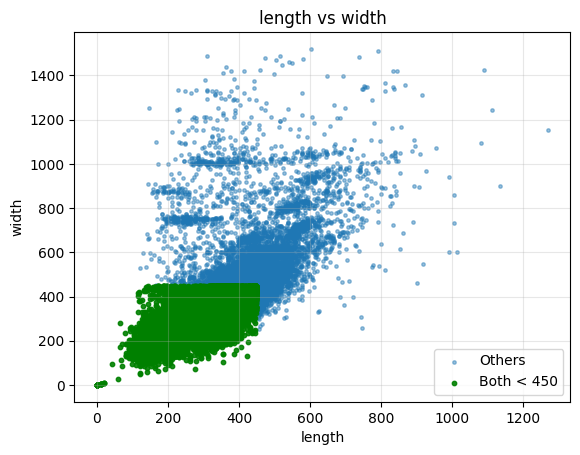

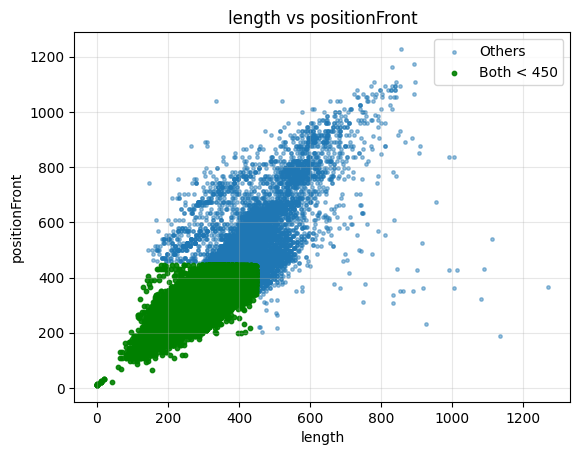

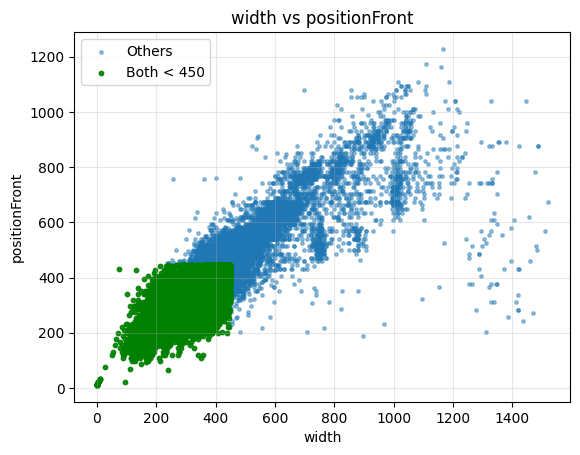

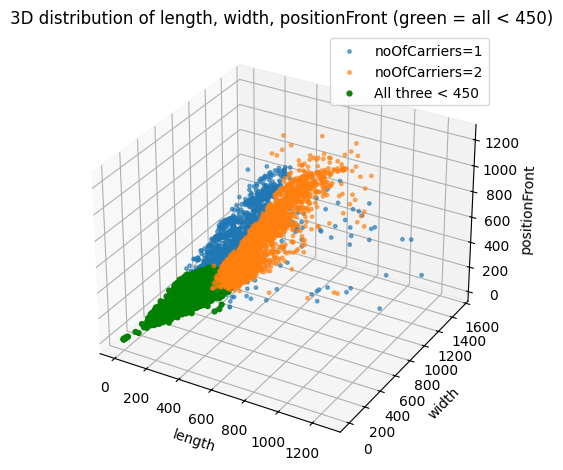

In [40]:
# --- CONFIG ---
X, Y, Z = "length", "width", "positionFront"
GROUP = "noOfCarriers"   # used for coloring "others" in 3D (keeps your distribution colors)
THRESH = 450
MAX_POINTS = 50000

# Ensure numeric
for col in [X, Y, Z, GROUP]:
    if col in clean_df.columns:
        clean_df[col] = pd.to_numeric(clean_df[col], errors="coerce")

# Drop rows missing the key columns
df = clean_df[[X, Y, Z, GROUP]].dropna(subset=[X, Y, Z]).copy()

# Optional subsample
if len(df) > MAX_POINTS:
    df = df.sample(MAX_POINTS, random_state=42)

# ---------- Helper to make 2D plot with green mask ----------
def scatter_2d(ax, df, a, b, thresh=THRESH, title=None):
    mask_valid = df[a].notna() & df[b].notna()
    mask_green = mask_valid & (df[a] < thresh) & (df[b] < thresh)

    # Plot others first (default color), then green on top
    ax.scatter(df.loc[mask_valid & ~mask_green, a],
               df.loc[mask_valid & ~mask_green, b],
               s=6, alpha=0.45, label="Others")

    ax.scatter(df.loc[mask_green, a],
               df.loc[mask_green, b],
               s=10, alpha=0.9, color="green", label=f"Both < {thresh}")

    ax.set_xlabel(a)
    ax.set_ylabel(b)
    if title:
        ax.set_title(title)
    ax.grid(True, alpha=0.3)
    ax.legend()

# 1) length vs width
fig, ax = plt.subplots()
scatter_2d(ax, df, X, Y, title=f"{X} vs {Y}")

# 2) length vs positionFront
fig, ax = plt.subplots()
scatter_2d(ax, df, X, Z, title=f"{X} vs {Z}")

# 3) width vs positionFront
fig, ax = plt.subplots()
scatter_2d(ax, df, Y, Z, title=f"{Y} vs {Z}")

# ---------- 3D plot with green mask ----------
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

mask_valid_3d = df[X].notna() & df[Y].notna() & df[Z].notna()
mask_green_3d = mask_valid_3d & (df[X] < THRESH) & (df[Y] < THRESH) & (df[Z] < THRESH)

# Plot "others" first, grouped (keeps distinct default colors for categories)
others = df.loc[mask_valid_3d & ~mask_green_3d]
if GROUP in others.columns:
    for g, gdf in others.groupby(GROUP):
        ax.scatter(gdf[X], gdf[Y], gdf[Z], s=6, alpha=0.6, label=f"{GROUP}={g}")    # type: ignore
else:
    ax.scatter(others[X], others[Y], others[Z], s=6, alpha=0.6, label="Others")  # type: ignore

# Plot the green cluster on top
greens = df.loc[mask_green_3d]
if not greens.empty:
    ax.scatter(greens[X], greens[Y], greens[Z], s=12, alpha=0.95, color="green", label=f"All three < {THRESH}")     # type: ignore

ax.set_xlabel(X)
ax.set_ylabel(Y)
ax.set_zlabel(Z)
ax.set_title(f"3D distribution of {X}, {Y}, {Z} (green = all < {THRESH})")
ax.legend()
plt.tight_layout()

plt.show()


In [41]:
# import pandas as pd
# import matplotlib.pyplot as plt
# import numpy as np

# # --- CONFIG ---
# induction_filter = ["IU005", "IU006", "IU007"]

# # 1. Filter dataset
# df_filtered = clean_df[clean_df['inductionNo'].isin(induction_filter)].copy()

# # 2. Compute gap (difference between consecutive positionFront per induction)
# df_filtered.sort_values(['inductionNo', 'positionFront'], inplace=True)
# df_filtered['gapRearToFront'] = df_filtered.groupby('inductionNo')['positionFront'].diff()

# # Remove rows where gap couldn't be computed (first item in each group)
# df_filtered = df_filtered.dropna(subset=['gapRearToFront'])

# # 3. Define bins and labels
# bins = [0, 0.4, 0.8, 1.4, 2, 3, 5, 10, np.inf]
# labels = ["0-0.4", "0.4-0.8", "0.8-1.4", "1.4-2", "2-3", "3-5", "5-10", ">10"]

# # 4. Bin the gaps
# df_filtered['gap_bin'] = pd.cut(df_filtered['gapRearToFront'], bins=bins, labels=labels)

# # 5. Count records per induction and bin
# gap_counts = df_filtered.groupby(['inductionNo', 'gap_bin']).size().unstack(fill_value=0)

# # 6. Plot grouped bar chart
# gap_counts.T.plot(kind='bar', figsize=(10, 6))
# plt.title('Gap Rear to Front for IU005, IU006, IU007')
# plt.xlabel('Gap (millimeters)')
# plt.ylabel('Count of records')
# plt.legend(title='Induction No')
# plt.grid(axis='y', linestyle='--', alpha=0.6)
# plt.tight_layout()
# plt.show()


Median gap (after scaling): 0.00 mm


C:\Users\joacosta\AppData\Local\Temp\ipykernel_43188\854745304.py:33: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  gap_counts = df_filtered.groupby(['inductionNo', 'gap_bin']).size().unstack(fill_value=0)


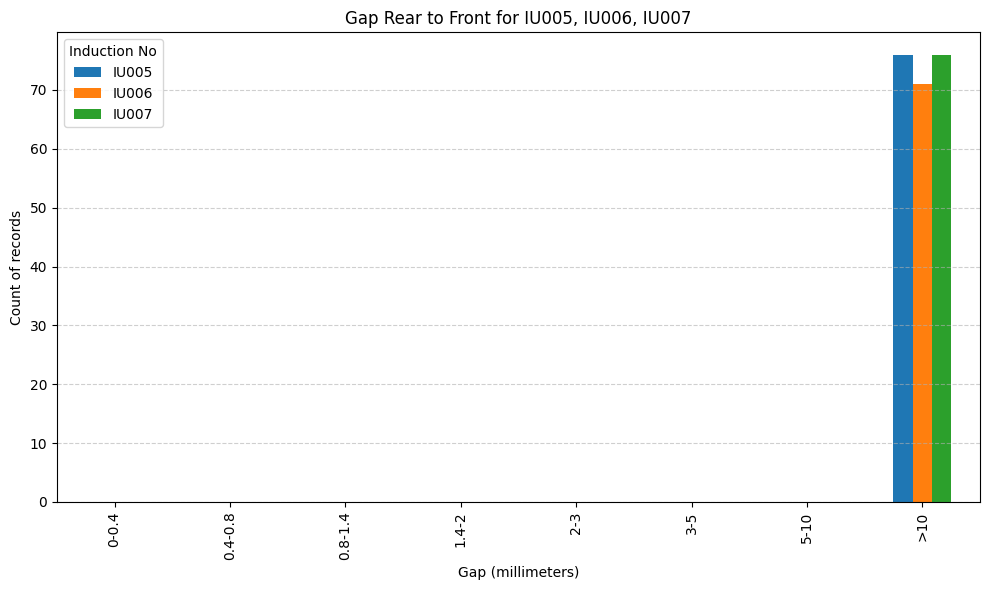

In [42]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# --- CONFIG ---
induction_filter = ["IU005", "IU006", "IU007"]

# 1. Filter dataset
df_filtered = clean_df[clean_df['inductionNo'].isin(induction_filter)].copy()

# 2. Compute gap (difference between consecutive positionFront per induction)
df_filtered.sort_values(['inductionNo', 'positionFront'], inplace=True)
df_filtered['gapRearToFront'] = df_filtered.groupby('inductionNo')['positionFront'].diff()
df_filtered = df_filtered.dropna(subset=['gapRearToFront'])

# 3. Auto-scale correction (detect possible micrometers or tenths of mm)
median_gap = df_filtered['gapRearToFront'].median()

if median_gap > 100:  # likely micrometers → convert to millimeters
    df_filtered['gapRearToFront'] /= 1000
elif median_gap > 10:  # likely tenths of mm → convert to mm
    df_filtered['gapRearToFront'] /= 10

print(f"Median gap (after scaling): {df_filtered['gapRearToFront'].median():.2f} mm")

# 4. Define bins and labels
bins = [0, 0.4, 0.8, 1.4, 2, 3, 5, 10, np.inf]
labels = ["0-0.4", "0.4-0.8", "0.8-1.4", "1.4-2", "2-3", "3-5", "5-10", ">10"]

df_filtered['gap_bin'] = pd.cut(df_filtered['gapRearToFront'], bins=bins, labels=labels)

# 5. Count records per induction and bin
gap_counts = df_filtered.groupby(['inductionNo', 'gap_bin']).size().unstack(fill_value=0)

# 6. Plot grouped bar chart
gap_counts.T.plot(kind='bar', figsize=(10, 6))
plt.title('Gap Rear to Front for IU005, IU006, IU007')
plt.xlabel('Gap (millimeters)')
plt.ylabel('Count of records')
plt.legend(title='Induction No')
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


In [43]:
import pandas as pd
import matplotlib.pyplot as plt

induction_filter = ["IU005", "IU006", "IU007"]

# Filter relevant inductions
df_filtered = clean_df[clean_df['inductionNo'].isin(induction_filter)].copy()

# Sort and compute consecutive gaps
df_filtered.sort_values(['inductionNo', 'positionFront'], inplace=True)
df_filtered['gapRearToFront'] = df_filtered.groupby('inductionNo')['positionFront'].diff()

# Drop NaNs (first row per group)
df_filtered = df_filtered.dropna(subset=['gapRearToFront'])


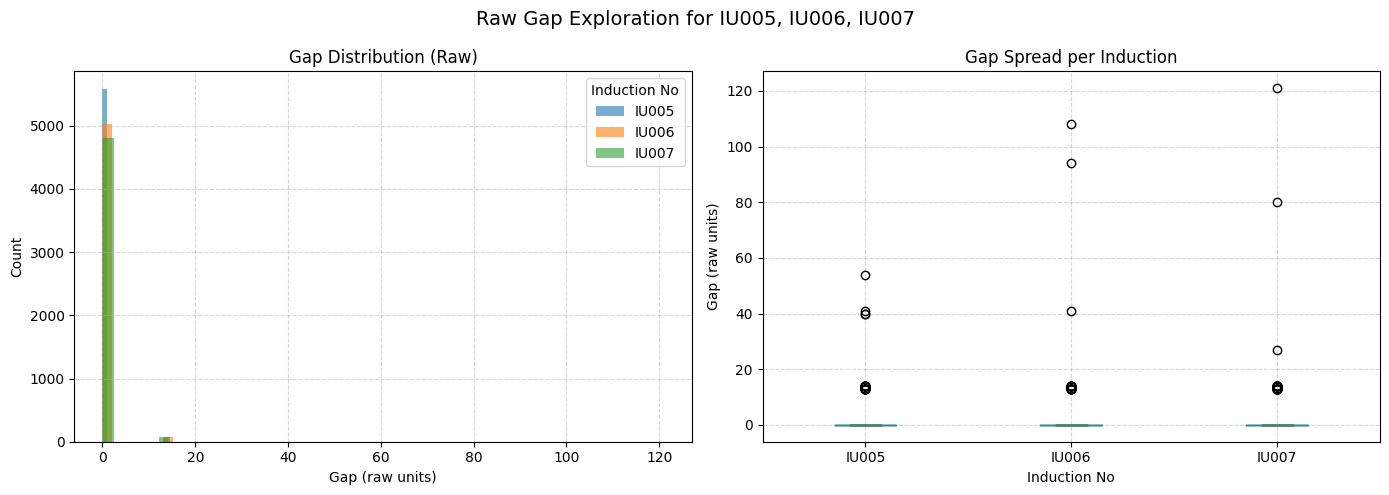

In [44]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Histogram
for induction, gdf in df_filtered.groupby('inductionNo'):
    axes[0].hist(gdf['gapRearToFront'], bins=50, alpha=0.6, label=induction)

axes[0].set_title('Gap Distribution (Raw)')
axes[0].set_xlabel('Gap (raw units)')
axes[0].set_ylabel('Count')
axes[0].legend(title='Induction No')
axes[0].grid(True, linestyle='--', alpha=0.5)

# Boxplot
df_filtered.boxplot(column='gapRearToFront', by='inductionNo', ax=axes[1])
axes[1].set_title('Gap Spread per Induction')
axes[1].set_xlabel('Induction No')
axes[1].set_ylabel('Gap (raw units)')
axes[1].grid(True, linestyle='--', alpha=0.5)

plt.suptitle('Raw Gap Exploration for IU005, IU006, IU007', fontsize=14)
plt.tight_layout()
plt.show()


In [45]:
# Quantile summary to see typical scale
print(df_filtered['gapRearToFront'].describe(percentiles=[0.5, 0.75, 0.9, 0.95, 0.99]))


count    15629.000000
mean         0.225286
std          2.397285
min          0.000000
50%          0.000000
75%          0.000000
90%          0.000000
95%          0.000000
99%         13.000000
max        121.000000
Name: gapRearToFront, dtype: float64
